# Gruppenprojekt ML-Sensordaten

## Aufgabe 1: Überblick über die Daten

Ziel der Aufgabe ist es durch das Laden der Daten und den ersten Schritten der EDA einen **Überblick über Wertebereich einzelner Features, mögliche Korrelationen, Ausreißer und fehlender Werte** zu bekommen.

Das hilft uns dabei in den weiteren Schritten besser mit den Daten umgehen zu können, in dem wir ein Gefühl für die Daten bekommen und mögliche Probleme frühzeitig erkennen.

### 1.1 Laden des Datensatzes und allen benötigten Paketen

- Einlesen der Datei `Dataensatz-Sensor.csv` mit `pandas.read_csv()`
- Setzen eines sinnvollen Index (hier: Zeitstempel 'Datum'), für spätere Analysen hilfreich
- Umwandlung der Spalte `Datum` in ein echtes Datumsformat (`datetime`), damit Zeitreihenanalysen und Resampling später einfacher werden

**Ziel dieser Zelle**: Sicherstellen, dass die Daten korrekt geladen wurden (keine offensichtlichen Fehler, korrekte Spaltennamen, sinnvolle Datentypen als Ausgangspunkt)

In [56]:
import pandas as pd
import matplotlib.pylab as plt
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyClassifier

df_sensor_raw = pd.read_csv('../data/Datensatz-Sensor.csv', parse_dates=['Datum'])

# Wir wollen direkt sagen, dass unsere Timestamps auch der Index sind
df_sensor_raw.set_index('Datum', inplace=True)
df_sensor_raw.head()

,Temperatur,Feuchtigkeit,CO2,Wassergehalt,Anwesenheit
Datum,,,,,
2015-02-02 14:19:00,23.7000,26.272,749.200000,0.004764,1
2015-02-02 14:19:59,23.7180,26.290,760.400000,0.004773,1
2015-02-02 14:21:00,23.7300,26.230,769.666667,0.004765,1
2015-02-02 14:22:00,23.7225,26.125,774.750000,0.004744,1
2015-02-02 14:23:00,23.7540,26.200,779.000000,0.004767,1


### 1.2 Erster Überblick über Struktur und Datentypen

Um die Grundstruktur der Daten zu verstehen, schauen wir uns zunächst folgende Aspekte an:

- Wie viele Zeilen und Spalten der Datensatz hat (`df.shape`)
- Welche Spalten vorhanden sind und welche Datentypen sie aktuell haben (`df.info()`)
- OB es bereits an dieser Stelle Hinweise auf Probleme gibt (bspw. numerische Spalten, als object)

**Ziel dieser Zelle**: Verständnis über den grundlegenden Aufbau des DataFrames und die aktuell gesetzten Datentypen für jedes Feature

In [57]:
df_sensor_raw.shape, df_sensor_raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19236 entries, 2015-02-02 14:19:00 to 2015-02-17 11:15:00
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Temperatur    19134 non-null  float64
 1   Feuchtigkeit  18915 non-null  float64
 2   CO2           19236 non-null  float64
 3   Wassergehalt  18777 non-null  float64
 4   Anwesenheit   19236 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 901.7 KB


((19236, 5), None)

### 1.3 Desriptive Statistiken und Wertebereiche der Features

Als nächstes betrachten wir einfache deskriptive Kennzahlen der numerischen Features, um grob die Wertebereiche zu erfassen:

- `df.describe()` liefert u.a. Minimum, Maximum, Mittelwert, Standardabweichung und Quantile
- Anhand von `min`und `max` können wir überprüfen, ob die Werte in realistischen Bereichen liegen (bspw. Temperatur in °C, Luftfeuchtigkeit in %. CO₂ in ppm, Wassergehalt in kg Wasserdampf/ kg Luft)
- Für die Zielvariable `Anwesenheit` prüfen wir, ob beide Klassen (0, 1) vorkommen und wie sie verteilt sind (Klassenbalance)

**Ziel dieser Zelle**: Ein erstes quantitatives Gefühl für typische Werte und Extreme der einzelnen Features zu bekommen.

In [58]:
# Deskriptive Statistiken
df_sensor_raw.describe()

,Temperatur,Feuchtigkeit,CO2,Wassergehalt,Anwesenheit
count,19134.000000,18915.000000,19236.000000,18777.000000,19236.000000
mean,21.322743,27.451396,634.818354,0.004189,0.226606
std,3.908221,5.008853,260.246196,0.000759,0.418647
min,19.000000,16.745000,0.000000,0.002674,0.000000
25%,20.133333,24.290000,454.500000,0.003699,0.000000
50%,20.675000,27.171429,545.500000,0.004278,0.000000
75%,21.600000,31.050000,734.541667,0.004799,0.000000
max,55.998944,39.500000,2028.500000,0.006476,1.000000


(Anwesenheit
 0    0.773394
 1    0.226606
 Name: proportion, dtype: float64,
 <Axes: >)

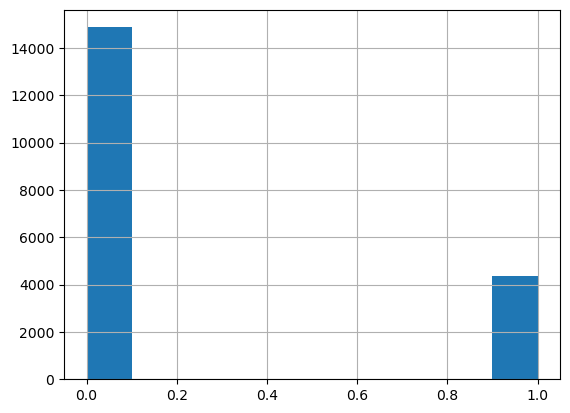

In [59]:
# Verteilung der Zielvariable (Klassenverteilung)
df_sensor_raw['Anwesenheit'].value_counts(normalize=True), df_sensor_raw['Anwesenheit'].hist()

### 1.4 Prüfung auf fehlende Werte

Fehlende Werte können ein Modell stark beeinflussen, daher prüfen wir frühzeitig, ob und wo `NaN`-Werte
auftreten:

- Mit `df.isna().sum()` sehen wir, wie viele fehlende Werte pro Spalte vorhanden sind.
- Falls Fehlstellen existieren, analysieren wir, ob diese zufällig verteilt sind oder systematisch, z. B. nur in bestimmten Zeitbereichen

**Ziel dieser Zelle:** Erkennen, ob im späteren Vorverarbeitungsschritt Strategien zum Umgang mit fehlenden
Werten (z. B. Imputation, Zeilenverwerfen) notwendig sind.

In [60]:
# Fehlende Werte je Spalte
df_sensor_raw.isna().sum().sort_values(ascending=False)

Wassergehalt    459
Feuchtigkeit    321
Temperatur      102
CO2               0
Anwesenheit       0
dtype: int64

In [61]:
# Schauen ob diese fehlende Werte zufällig oder in bestimmten Zeitbereichen
(
    df_sensor_raw
        .isna()
        .groupby(df_sensor_raw.index.date)
        .sum()
)

,Temperatur,Feuchtigkeit,CO2,Wassergehalt,Anwesenheit
2015-02-02,3,5,0,20,0
2015-02-03,11,16,0,36,0
2015-02-04,5,20,0,22,0
2015-02-05,10,14,0,35,0
2015-02-06,7,33,0,37,0
2015-02-07,8,26,0,44,0
2015-02-08,9,35,0,34,0
2015-02-09,7,28,0,20,0
2015-02-10,1,9,0,12,0
2015-02-11,1,13,0,15,0


In [53]:
(df_sensor_raw.index.to_series().diff().value_counts().head(10))

Datum
0 days 00:01:00    11535
0 days 00:00:59     3849
0 days 00:01:01     3849
0 days 07:08:00        1
1 days 05:15:00        1
Name: count, dtype: int64

In [54]:
gaps = df_sensor_raw.index.to_series().diff()
gaps[gaps > pd.Timedelta("10min")]

Datum
2015-02-04 17:51:00   0 days 07:08:00
2015-02-11 14:48:00   1 days 05:15:00
Name: Datum, dtype: timedelta64[ns]